# Data Scientist Professional Case Study

### Company Background

Snow Cone Games are a digital retailer for video games. The website includes a simple filter for the genre of the game as well as more advanced filtering. The product manager has recently learned that only 23% of buyers search for games using the genre filter. 

71% of buyers use advanced filters to find the types of games that appeal to them. The product manager hopes that new categories based on different game attributes can help players find what they are looking for faster.


### Customer Question

The product manager would like to know:
- Can you use the data from 40,000 games to identify groupings of games that are most similar to each other?


### Success Criteria

Ideally, there would be no more than five groupings. Any more would make it much harder to display on the page so there would need to be a good reason to have more.


### Dataset

The data you will use for this analysis can be accessed here: `"video_games.csv"`

# Introduction
The purpose of this report is to describe the results obtained from a model that identifies and groups games based on similar characteristics. The goal of this project is to create a model that will help players find what they are looking for faster. The product manager of Snow Cone Games discovered that only 23% of buyers use the genre filter and 71% of buyers use advanced filtering to find games that appeal to them. This means that the genre filter is not filtering results well, and players turn to advanced filters to get the results that they want. However, using advanced filters can be a hassle and make searching for games take much longer. Ultimately, this will affect the user experience and possibly affect the sales in Snow Cone Games.   

# Exploratory Data Analysis and Preprocessing
The data used for this analysis is `"data/video_games.csv"`. It contains over 40000 rows of data on different video games with fields such as name, release date, original price, and more. We will perform Exploratory Data Analysis to learn more about the table.  

In [5]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
games = pd.read_csv('video_games.csv') 
games.head()

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
0,DOOM,"May 12, 2016",id Software,54.0,$19.99,92%,42550.0,True,False
1,PLAYERUNKNOWN'S BATTLEGROUNDS,"Dec 21, 2017",PUBG Corporation,37.0,$29.99,49%,836608.0,True,True
2,BATTLETECH,"Apr 24, 2018",Harebrained Schemes,128.0,$39.99,71%,7030.0,True,False
3,DayZ,"Dec 13, 2018",Bohemia Interactive,NaN,$44.99,61%,167115.0,True,False
4,EVE Online,"May 6, 2003",CCP,NaN,Free,74%,11481.0,True,False


In [6]:
games.describe()

,achievements,num_reviews
count,12194.000000,17363.000000
mean,77.237494,1302.647238
std,448.501848,11547.306156
min,1.000000,10.000000
25%,12.000000,23.000000
50%,21.000000,63.000000
75%,38.000000,297.000000
max,9821.000000,836608.000000


In [7]:
# Observe datatypes of each column
print(games.info())
print("\nNumber of Missing Values by Column")
print(games.isna().sum()) #Missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40833 entries, 0 to 40832
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              40817 non-null  object 
 1   release_date      37654 non-null  object 
 2   developer         40490 non-null  object 
 3   achievements      12194 non-null  float64
 4   original_price    35522 non-null  object 
 5   percent_positive  17363 non-null  object 
 6   num_reviews       17363 non-null  float64
 7   multiplayer       40313 non-null  object 
 8   mature            40833 non-null  bool   
dtypes: bool(1), float64(2), object(6)
memory usage: 2.5+ MB
None

Number of Missing Values by Column
name                   16
release_date         3179
developer             343
achievements        28639
original_price       5311
percent_positive    23470
num_reviews         23470
multiplayer           520
mature                  0
dtype: int64


The table contains 40,833 rows and 9 different columns. The output of games_info shows that the table has data type errors that must be converted. The column "multiplayer" should be of type boolean, "percent_positive" and "original_price" should be of type float, and "release_date" should be a datetime object. There are also many NaN values we must take care of and duplicates that need to be handled. We will have to preprocess and clean the data to use it for our model. First, we will handle the duplicates.

In [ ]:
#Handle duplicates
duplicates = games.duplicated()
print(games[duplicates].sort_values(by='name'))
games = games.drop_duplicates()

Since the duplicates mostly contain NaN values, we should just drop them. After dropping the duplicates, we can handle the data type errors. First, we will treat the "percent_positive" column. 

In [8]:
print(games['percent_positive'])

0        92%
1        49%
2        71%
3        61%
4        74%
        ... 
40828    NaN
40829    NaN
40830    NaN
40831    NaN
40832    NaN
Name: percent_positive, Length: 40833, dtype: object


Notice that the column is of type object (string), which means we must convert it to a float (or int). We have to remove the "%" from each entry and then convert it to a float.

In [9]:
#Change percent_positive column to be of type float by removing percent
games['percent_positive'] = games['percent_positive'].str.strip('%').astype('float')
print("The column percent_positive is of type:",str(games['percent_positive'].dtype))

The column percent_positive is of type: float64


Now we can convert the "multiplayer" column to boolean and "release_date" to a datetime object.


In [10]:
#Change multiplayer column to be of type bool
games['multiplayer'] = games['multiplayer'].astype('bool')
print("The column multiplayer is of type:",str(games['multiplayer'].dtype))
#Change release date to datetime object
games['release_date'] = pd.to_datetime(games['release_date'], infer_datetime_format=True, errors='coerce')
print("The column release_date is of type:",str(games['release_date'].dtype))


The column multiplayer is of type: bool
The column release_date is of type: datetime64[ns]


The last column we need to change is the "original_price" column. The column should contain floats where each entry represents the price of each game, but the entries are all strings. First, let's observe the strings in the "original_price" column

In [11]:
#Create list of values in original_price
a = list(games['original_price'].unique())
print(a)

['$19.99', '$29.99', '$39.99', '$44.99', 'Free', nan, '$59.99', '$14.99', '$49.99', 'Free to Play', '1.020', 'Free To Play', '$9.99', '$12.99', '$57.91', '$7.99', '$6.99', '$24.99', 'Demo Middle-earth™: Shadow of War™', 'Play for Free!', '$13.99', '$59.98', '$69.99', '$76.95', '$84.97', '$58.89', '$8.99', '$75.95', '$34.99', '$151.89', '$4.99', '$84.93', '$86.92', '$20.00', '$15.99', '$9.98', 'Shadow of the Tomb Raider Free Trial', '$5.99', '$11.99', '$32.98', '$21.98', 'FINAL FANTASY XV WINDOWS EDITION PLAYABLE DEMO', '$28.00', 'UNO', '$79.99', '$59.95', '$3.99', '$30.00', '$17.99', '$57.98', '$84.98', '$229.48', '$269.69', '$29.98', '$31.99', '$16.99', '$52.98', '$39.98', '$41.98', '$1.99', '$99.99', '$2.99', '$10.99', '$264.82', '$20.99', 'Demo', 'CrossCode Demo', '$88.94', '$149.99', '$36.99', '$18.99', '$19.98', '$89.99', '$25.99', '$116.93', 'EmergeNYC Demo', '$37.99', '$67.96', 'SpeedRunners Party Mode', '$399.00', 'Learn to Play Edition', 'Soundpad Demo', '$34.97', 'Try the com

The "original_price" column has many strings that are floats with dollar signs. Let's remove the dollar sign first.

In [12]:
games['original_price'] = games['original_price'].str.strip('$') #Removed dollar signs from strings
print(list(games['original_price'].unique()))

['19.99', '29.99', '39.99', '44.99', 'Free', nan, '59.99', '14.99', '49.99', 'Free to Play', '1.020', 'Free To Play', '9.99', '12.99', '57.91', '7.99', '6.99', '24.99', 'Demo Middle-earth™: Shadow of War™', 'Play for Free!', '13.99', '59.98', '69.99', '76.95', '84.97', '58.89', '8.99', '75.95', '34.99', '151.89', '4.99', '84.93', '86.92', '20.00', '15.99', '9.98', 'Shadow of the Tomb Raider Free Trial', '5.99', '11.99', '32.98', '21.98', 'FINAL FANTASY XV WINDOWS EDITION PLAYABLE DEMO', '28.00', 'UNO', '79.99', '59.95', '3.99', '30.00', '17.99', '57.98', '84.98', '229.48', '269.69', '29.98', '31.99', '16.99', '52.98', '39.98', '41.98', '1.99', '99.99', '2.99', '10.99', '264.82', '20.99', 'Demo', 'CrossCode Demo', '88.94', '149.99', '36.99', '18.99', '19.98', '89.99', '25.99', '116.93', 'EmergeNYC Demo', '37.99', '67.96', 'SpeedRunners Party Mode', '399.00', 'Learn to Play Edition', 'Soundpad Demo', '34.97', 'Try the complete game for one hour for free:', '45.97', '105.72', 'LudoNarraCo

Now we have to treat the strings that are not floats. Since there is no clear way to determine what the original price is for these games, we will replace the strings with NaN values. This way we can do a simple imputation later on. Once we replace the strings with NaNs then we can change the "original_price" column to be of type float.

In [13]:
float_check = games['original_price'].str.replace('.','')\
						.str.isdigit() #Checks to see if string is numeric
not_floats = len(games['original_price'])- float_check.sum()
print("There are",str(not_floats),"strings that are not floats.")
games.loc[float_check == False ,"original_price"]=np.nan #Any string that is not a number will get replaced with NaN 
games['original_price'] = games['original_price'].astype('float')
print("The column original_price is of type:",str(games['original_price'].dtype))

There are 8329 strings that are not floats.
The column original_price is of type: float64


/var/folders/6h/qsqz2pt10p3_y_t5vd3v6l5w0000gn/T/ipykernel_12960/1810013776.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  float_check = games['original_price'].str.replace('.','')\


Another important step we must consider is dealing with the missing values in each column. We cannot simply drop the missing values because we would lose a lot of valuable data for our model. A solution is to impute a statistic for the NaN values. Before we impute the NaN values, we should first remove the outliers in the data and observe the distribution of each column to figure out the best statistic to impute. First, let's observe the number of missing values in each column

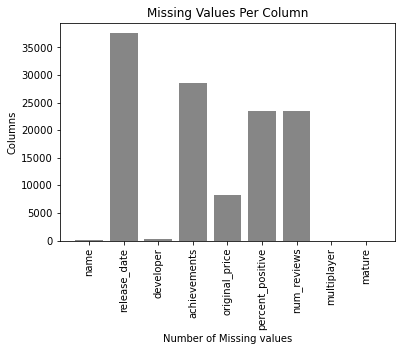

                                                  name release_date  \
37635                                      Railgunners          NaT   
18639                    Slime-san: Superslime Edition          NaT   
40238                               Valve Index VR Kit          NaT   
38148  Strata Spaces VR – Professional Edition Upgrade          NaT   
40235                Valve Index Headset + Controllers          NaT   
...                                                ...          ...   
40816                                            VICCP          NaT   
40822      Bare Boob Brawlerz: Novel 01 (Visual Novel)          NaT   
40823                                      Gamers Club          NaT   
40824                                           Gravia          NaT   
40826                                            Alive          NaT   

                        developer  achievements  original_price  \
37635            Expresso Studios           NaN        730640.0   
18639        

In [14]:
plt.bar(games.columns, games.isna().sum(), color='#868686')
plt.xticks(rotation=90)
plt.title("Missing Values Per Column")
plt.xlabel('Number of Missing values')
plt.ylabel('Columns')
plt.show()
print(games.sort_values('original_price', ascending = False))

Thus, dropping NaN values would be a huge loss of data so we need to impute the NaN values. Next, we have to consider outliers. We will not be removing the outliers for the columns "percent_positive", "num_reviews", or "achievements" because each data point is important despite there being outliers. Popular games will likely have higher values in "num_reviews" and "achievements" so it is important that we include them. The "percent_positive" values all fall in the range of 0% to 100%, which means that every value is valid. Also, removing outliers from each of these columns would mean losing thousands of rows of data. However, the "original_price" column has outliers that need to be removed because they are not informative and will affect the performance of our model. For example, the video game "Railgunners" has an original_price of $730,640.00, which is absurd. We can define a function remove_outliers() that will remove the outliers of a column in our DataFrame.

In [16]:
from scipy.stats import iqr
def remove_outliers(df, column):
    """ 
    Removes outliers in a numeric column of a dataframe
    Arguments:
    df -- pandas DataFrame
    column -- column name 
    Returns DataFrame
    """
    temp = df.dropna(subset=[column]) #Drops null values in column
    iqr_df = iqr(temp[column])
    lower_threshold = np.quantile(temp[column],0.25)-1.5*iqr_df
    upper_threshold = np.quantile(temp[column],0.75)+1.5*iqr_df
    outliers =(temp[column]<lower_threshold)|(temp[column]>upper_threshold)
    temp = temp[outliers]
    print("There are",str(len(temp)),"outliers in", str(column))
    # Left anti join
    result = df.merge(temp, how="left", on = column, indicator=True)
    out_list = result.loc[result['_merge'] == 'left_only', column]
    fin = df[df[column].isin(out_list)] 
    return fin

games = remove_outliers(games,'original_price')
print(games.describe())


There are 2700 outliers in original_price
       achievements  original_price  percent_positive    num_reviews
count  11138.000000    29804.000000      15815.000000   15815.000000
mean      61.960136        7.407214         74.822890    1062.598103
std      369.057298        5.991589         18.720091    8765.995193
min        1.000000        0.500000          0.000000      10.000000
25%       11.000000        2.990000         64.000000      22.000000
50%       20.000000        4.990000         79.000000      59.000000
75%       35.000000        9.990000         90.000000     264.000000
max     9821.000000       27.990000        100.000000  553458.000000


The function takes in the DataFrame and column name as parameters, and returns the DataFrame without outliers. We can see that our new max for "original_price" is $27.99. Now we can view the distribution of each column to find the best statistic to impute. 


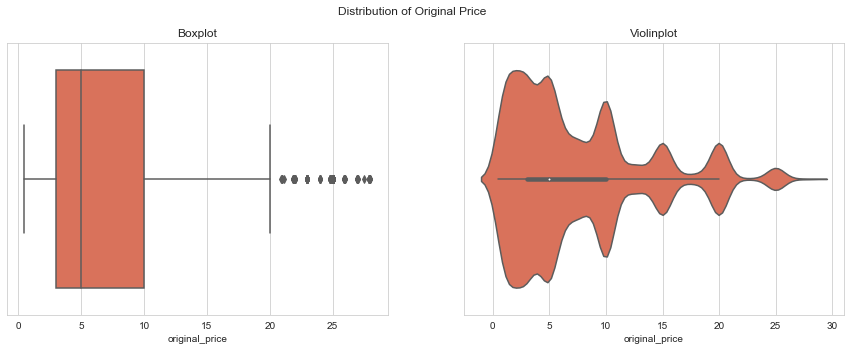

In [17]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,2, figsize=(15, 5))
fig.suptitle('Distribution of Original Price')
sns.boxplot(ax= ax[0], x = 'original_price', data=games, color="#EE6446")
ax[0].set_title("Boxplot")
sns.violinplot(ax= ax[1], x = 'original_price', data=games,color="#EE6446")
ax[1].set_title("Violinplot")
plt.show()

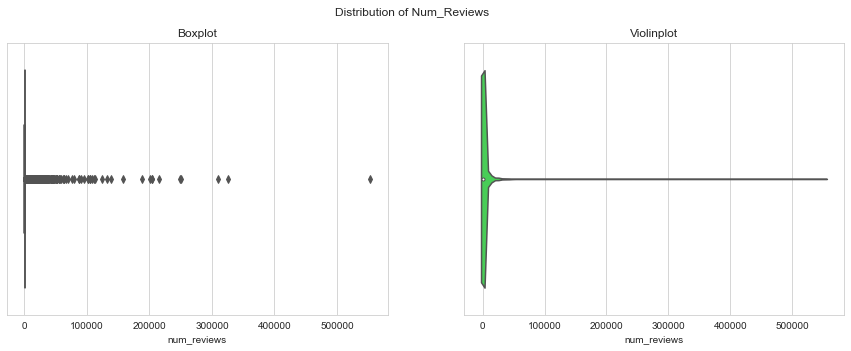

In [18]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
fig.suptitle('Distribution of Num_Reviews')
sns.boxplot(ax= ax[0], x = 'num_reviews', data=games, color="#33E346")
ax[0].set_title("Boxplot")
sns.violinplot(ax= ax[1], x = 'num_reviews', data=games,color="#33E346")
ax[1].set_title("Violinplot")
plt.show()

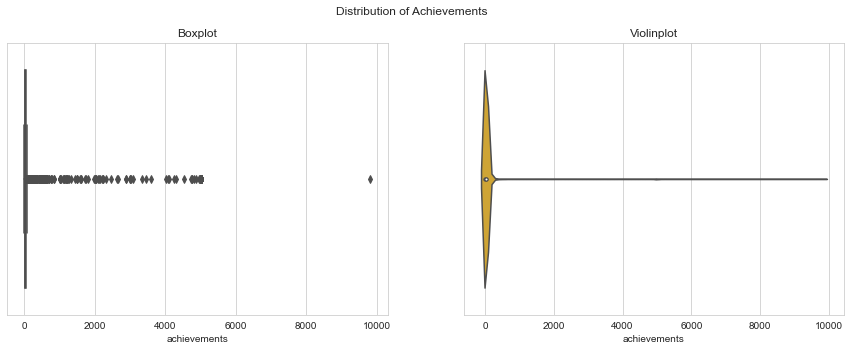

In [19]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
fig.suptitle('Distribution of Achievements')
sns.boxplot(ax= ax[0], x = 'achievements', data=games, color="#E8B01B")
ax[0].set_title("Boxplot")
sns.violinplot(ax= ax[1], x = 'achievements', data=games, color="#E8B01B")
ax[1].set_title("Violinplot")
plt.show()

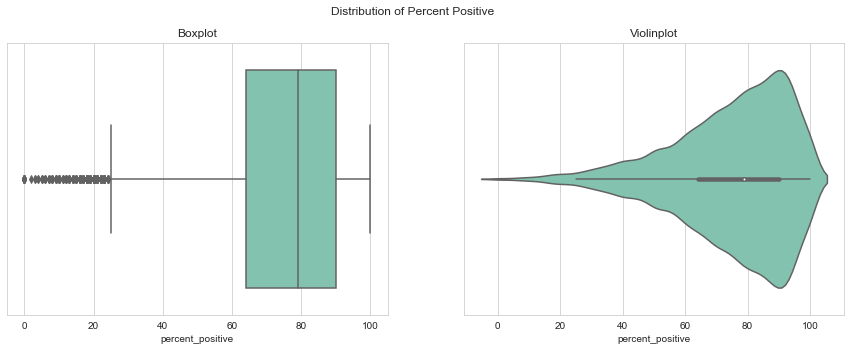

In [20]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
fig.suptitle('Distribution of Percent Positive')
sns.boxplot(ax= ax[0], x = 'percent_positive', data=games, color='#79ccb3')
ax[0].set_title("Boxplot")
sns.violinplot(ax= ax[1], x = 'percent_positive', data=games, color='#79ccb3')
ax[1].set_title("Violinplot")
plt.show()

The plots of "percent_positive", "num_reviews", and "achievements" are very compressed because we did not to remove the outliers. Observing the graphs, we can still tell that the data is very skewed. This tells us that using mean imputation wouldn't be ideal since the mean is not a good measure of center in these distributions. Instead, we should impute the median or mode for the null values. Here we will impute the median.

In [21]:
games = games.drop(columns=['name','release_date','developer'])
#Fill na values
impute_dict = {}
for col in games.columns:
    x = np.array(games[col])
    med = np.median(x[~np.isnan(x)]) # Calculates median ignoring NaN values
    impute_dict[col]=med
print(impute_dict)
games = games.fillna(impute_dict)

print(games.isna().sum())

{'achievements': 20.0, 'original_price': 4.99, 'percent_positive': 79.0, 'num_reviews': 59.0, 'multiplayer': 0.0, 'mature': 0.0}
achievements        0
original_price      0
percent_positive    0
num_reviews         0
multiplayer         0
mature              0
dtype: int64


In [22]:
#Turn boolean columns to integer columns
games['multiplayer'] = games['multiplayer'].astype('int')
games['mature'] = games['mature'].astype('int')

Now that we've imputed for the NaN values and have no missing values in our numeric columns, we can finally create a model and fit it to our data. First, we have to standardize our data so that each feature has an equal variance and then use dimension reduction (PCA) to get the principal features. Once we finish we preprocessing our data, we will apply it to a k-means clustering model.

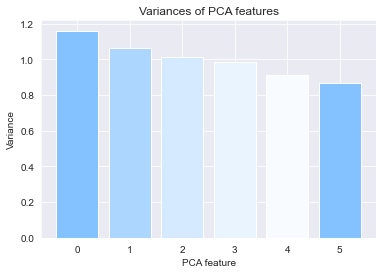

In [24]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler() #Standardize data
scaled_data = scaler.fit_transform(games)
pca = PCA()
pca.fit(scaled_data)
features = range(pca.n_components_)
sns.set_style("darkgrid")
plt.bar(features, pca.explained_variance_, color = ["#84c1ff", "#add6ff", "#d6eaff", "#eaf4ff", "#f8fbff"])
plt.title("Variances of PCA features")
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features)
plt.show()


We will pick the first 3 PCA components to use in our model. Then, we will apply it to the standardized data.

In [25]:
pca = PCA(n_components=3) #Dimension reduction
pca_scores = pca.fit_transform(scaled_data)

Now we want to figure out what is the optimal amount of clusters for our k-means model. In the instructions, we are told that we want no more than 5 groupings, which means that our clusters will range from 1 to 5. We can fit our k-means model to the pca scores and extract the .inertia_ attribute. Afterwards, we will graph the inertias and use the elbow method to find the optimal number of clusters.

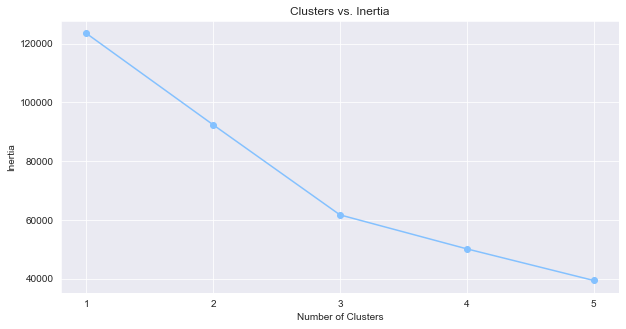

In [26]:
inertias=[]
for i in range(1,6):
    km = KMeans(n_clusters=i)
    km.fit(pca_scores)
    inertias.append(km.inertia_)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1,6), inertias, marker='o', c = "#84c1ff")
ax.set_title("Clusters vs. Inertia")
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range(1,6))
plt.show()

From the graph we see that the optimal amount of clusters is 3. Thus, we can generate our cluster labels with KMeans.

In [27]:
from sklearn.pipeline import make_pipeline
km_pca = KMeans(n_clusters=3, random_state=21)
labels = km_pca.fit_predict(pca_scores)
games['clusters'] = labels
games.head()

,achievements,original_price,percent_positive,num_reviews,multiplayer,mature,clusters
0,54.0,19.99,92.0,42550.0,1,0,2
4,20.0,4.99,74.0,11481.0,1,0,2
5,20.0,4.99,79.0,59.0,1,0,2
7,55.0,14.99,91.0,23763.0,1,0,2
10,72.0,19.99,83.0,4600.0,1,0,2


In [28]:
print(games['clusters'].value_counts().sort_values(ascending=False))

0    24382
2    13674
1       77
Name: clusters, dtype: int64


We see that cluster 0 has 24,382 data points, cluster 1 has 77 data points, and cluster 2 has 13,660 data points. Now let's visualize the clusters using the first two PCA components in our axes. Note that distortion is inevitable since we are only using the first two PCA components. 

/Users/stevenortiz/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


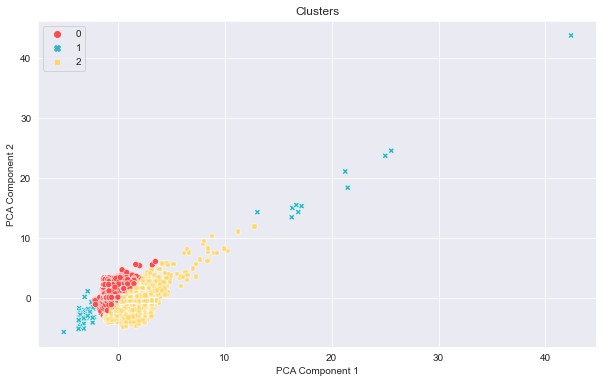

In [29]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 6))
color_palette = ['#fe4a49','#2ab7ca','#fed766']
ax.set_title("Clusters")
x = pca_scores[:,0]
y = pca_scores[:,1]
sns.scatterplot(x,y,data=games, hue=labels, style=labels, palette = color_palette)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Conclusion
In summary, we want to know if there's a way to identify groupings of games that are most similar to each other. First, we cleaned and preprocessed the data by removing duplicates, fixed data types of columns, imputed for missing values, and removed outliers. Since this is an unsupervised learning problem, we used clustering with a k-means model. We standardized the data, used dimension reduction, and then generated the cluster labels. Finally, we plotted the data to visualize our cluster. The graphs shows the 3 clusters our k-means model generated. Notice that the clusters are tight, which is a good sign that our model performed well. If this model was implemented, then it would group the games according to the clusters. Thus, similer games will automatically appear in a basic search, which means that the advanced search isn't required. Ultimately, our model will improve the searching in the Snow Cone Games website and make basic searches quicker and more efficient.

# Future Work
After implementing our clustering algorithm to the search filter, we want to measure how well our algorithm performs. We can perform A/B testing by measuring the percentage of buyers that used the genre filter and the advanced filter after the algorithm is implemented and compare those numbers with the ones obtained before the algorithm was implemented. Then, we may perform hypothesis testing to see if the difference is statistically significant. We can go even further to measure the sales before and after the algorithm is implemented using A/B testing. This would give us a good metric to see if model is effective